In [31]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]

In [2]:
from scipy.signal import savgol_filter

### Shape of data

In [32]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Plot a trial

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

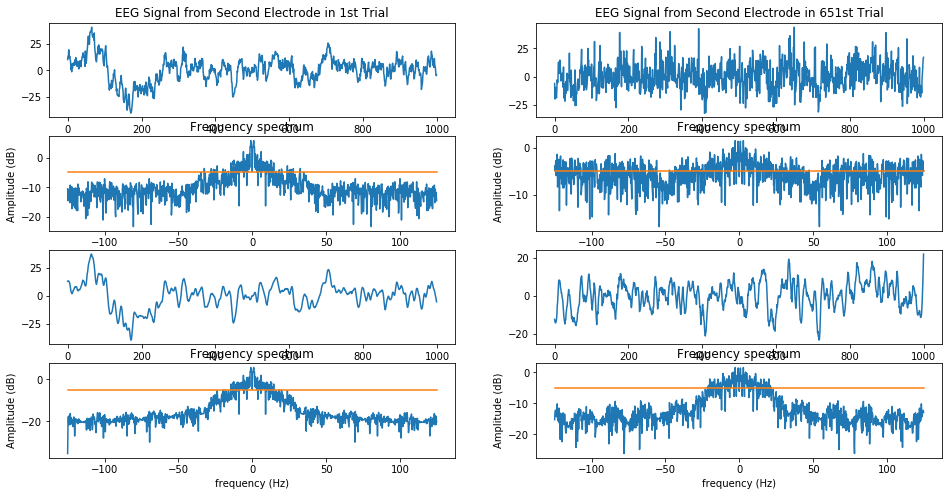

In [44]:
plt.figure(figsize=(16,8))

# Time Domain Plot before filtering
plt.subplot(4,2,1)
plt.plot(X_train_valid[1, 1])
plt.title('EEG Signal from Second Electrode in 1st Trial')

plt.subplot(4,2,2)
plt.plot(X_train_valid[651, 1])
plt.title('EEG Signal from Second Electrode in 651st Trial')


# Frequency Domain Plot before filtering
plt.subplot(4,2,3)
plot_spectrum(250, X_train_valid[1, 1])

plt.subplot(4,2,4)
plot_spectrum(250, X_train_valid[651, 1])


# Time Domain Plot after filtering
plt.subplot(4,2,5)
plt.plot(savgol_filter(X_train_valid[1, 1], 13, 2))

plt.subplot(4,2,6)
plt.plot(savgol_filter(X_train_valid[651, 1], 13, 2))



# Frequency Domain Plot after filtering
plt.subplot(4,2,7)
plot_spectrum(250, savgol_filter(X_train_valid[1, 1], 13, 2))

plt.subplot(4,2,8)
plot_spectrum(250, savgol_filter(X_train_valid[651, 1], 13, 2))


plt.show()

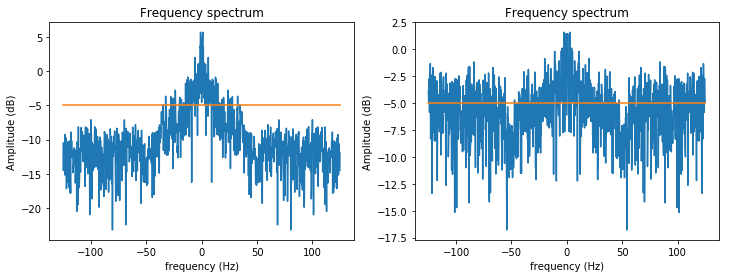

In [41]:
plt.figure(figsize=(12,4))



plt.show()

In [5]:
def plot_signal_trial(X):
    '''
    X: X: 2D ndarray, EEG time series signals in a trial
    '''
    n_electrode = X.shape[0]

    plt.figure(figsize=(20,40))

    for i in range(n_electrode):
        plt.subplot(n_electrode,1,i+1)
        plt.plot(X[i])

    plt.show()

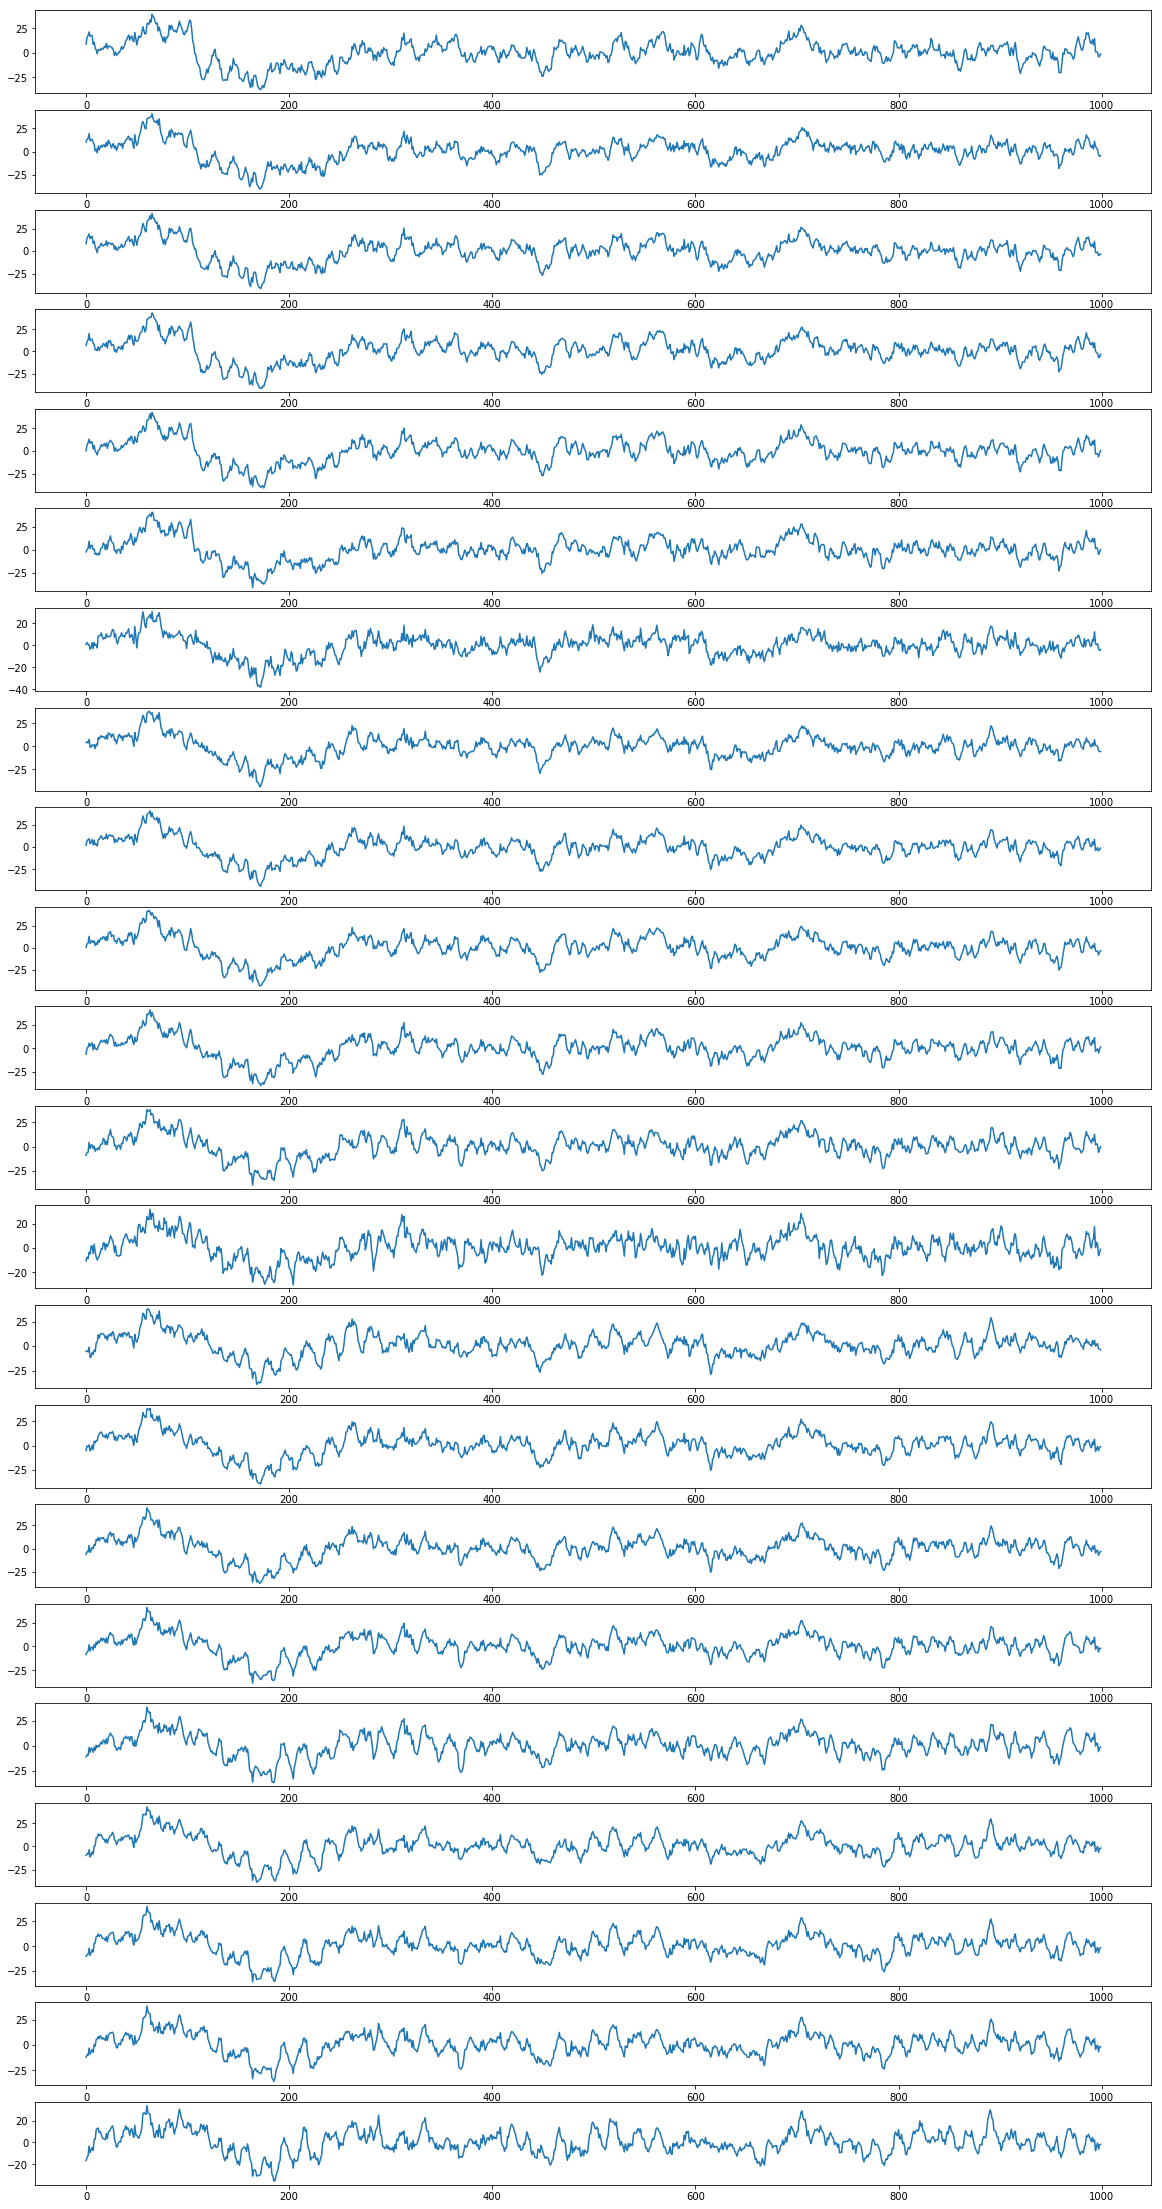

In [33]:
plot_signal_trial(X_train_valid[1])

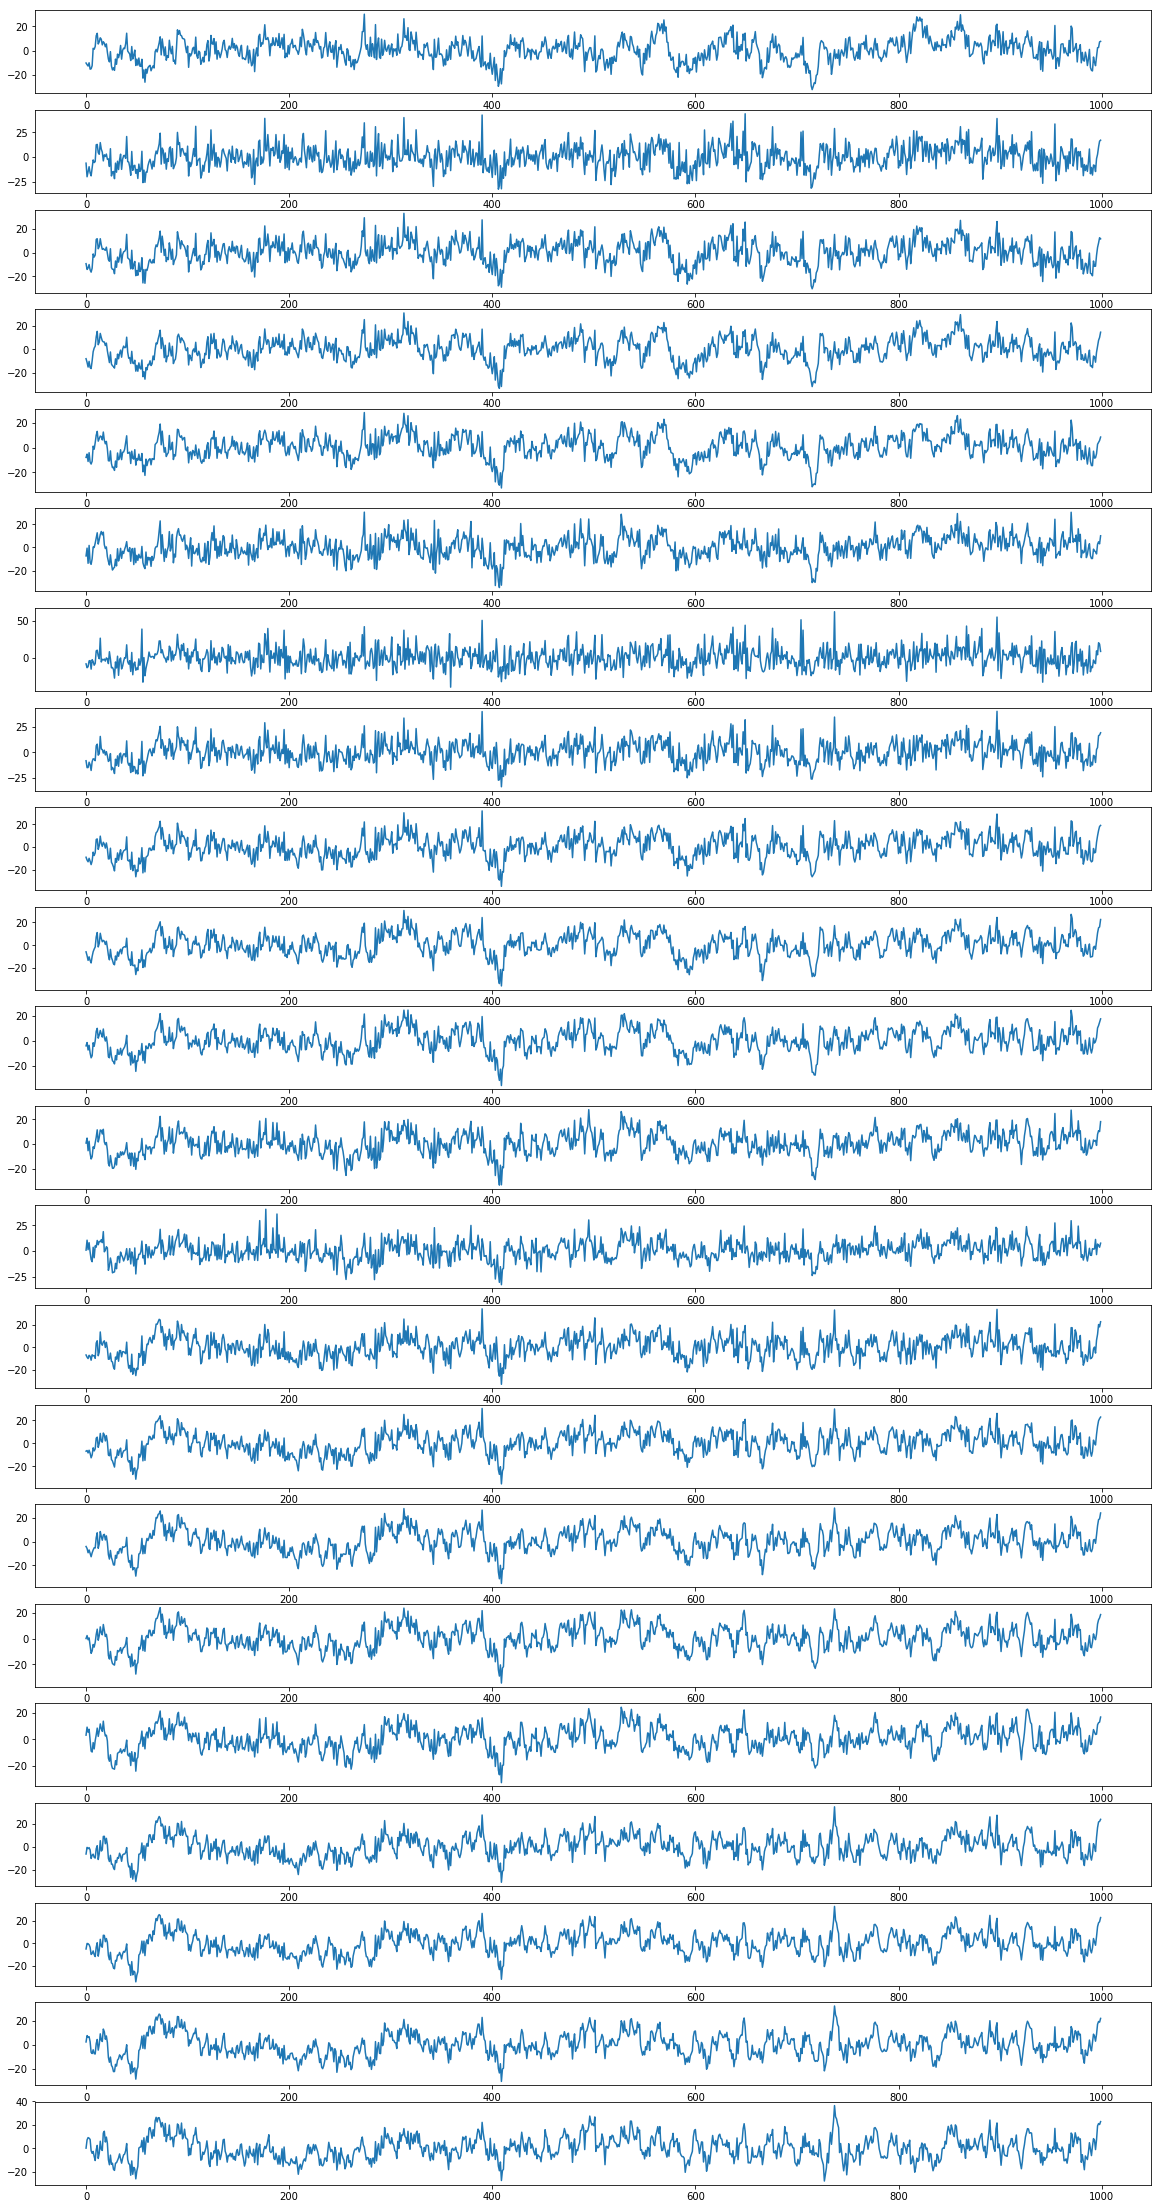

In [34]:
plot_signal_trial(X_train_valid[651])

### Spectrum Analysis

The signals were sampled with 250 Hz and bandpass-ﬁltered between 0.5 Hz and 100 Hz. The sensitivity of the ampliﬁer was set to 100 µV. An additional 50 Hz notch ﬁlter was enabled to suppress line noise.

In [6]:
f_s = 250  # sampling frequency: 250Hz

In [7]:
def plot_spectrum(f_s, X): 
    '''
    Input: 
    f_s: sampling frequency
    X: 1D ndarray, time series signal
    
    To Do: 
    Plot the Frequency 
    '''
    n_s = len(X)  # number of sample points
    timestep = 1/f_s  

    spectrum = np.abs(np.fft.fft(X))/n_s # Normalize by deviding n_s
    spectrum_dB = 10*np.log10(spectrum)

    freq = np.fft.fftfreq(n_s, timestep)

    idx = np.argsort(freq)
    
    y_thre = -5*np.ones(n_s) # show the -5dB threshold

    plt.plot(freq[idx], spectrum_dB[idx], freq[idx], y_thre)
    plt.xlabel('frequency (Hz)')
    plt.title('Frequency spectrum')
    plt.ylabel('Amplitude (dB)')


In [8]:
def plot_spectrum_trail(f_s, X):
    '''
    Input: 
    f_s: sampling frequency
    X: 2D ndarray, EEG time series signals in a trial
    
    To Do: 
    Plot the Frequency Spectrum for all electrode in this trial
    '''
    plt.figure(figsize=(10,50))
    
    n_electrode = X.shape[0]

    for i in range(n_electrode):
        plt.subplot(n_electrode,1,i+1)
        plot_spectrum(f_s, X[i])

    plt.show()

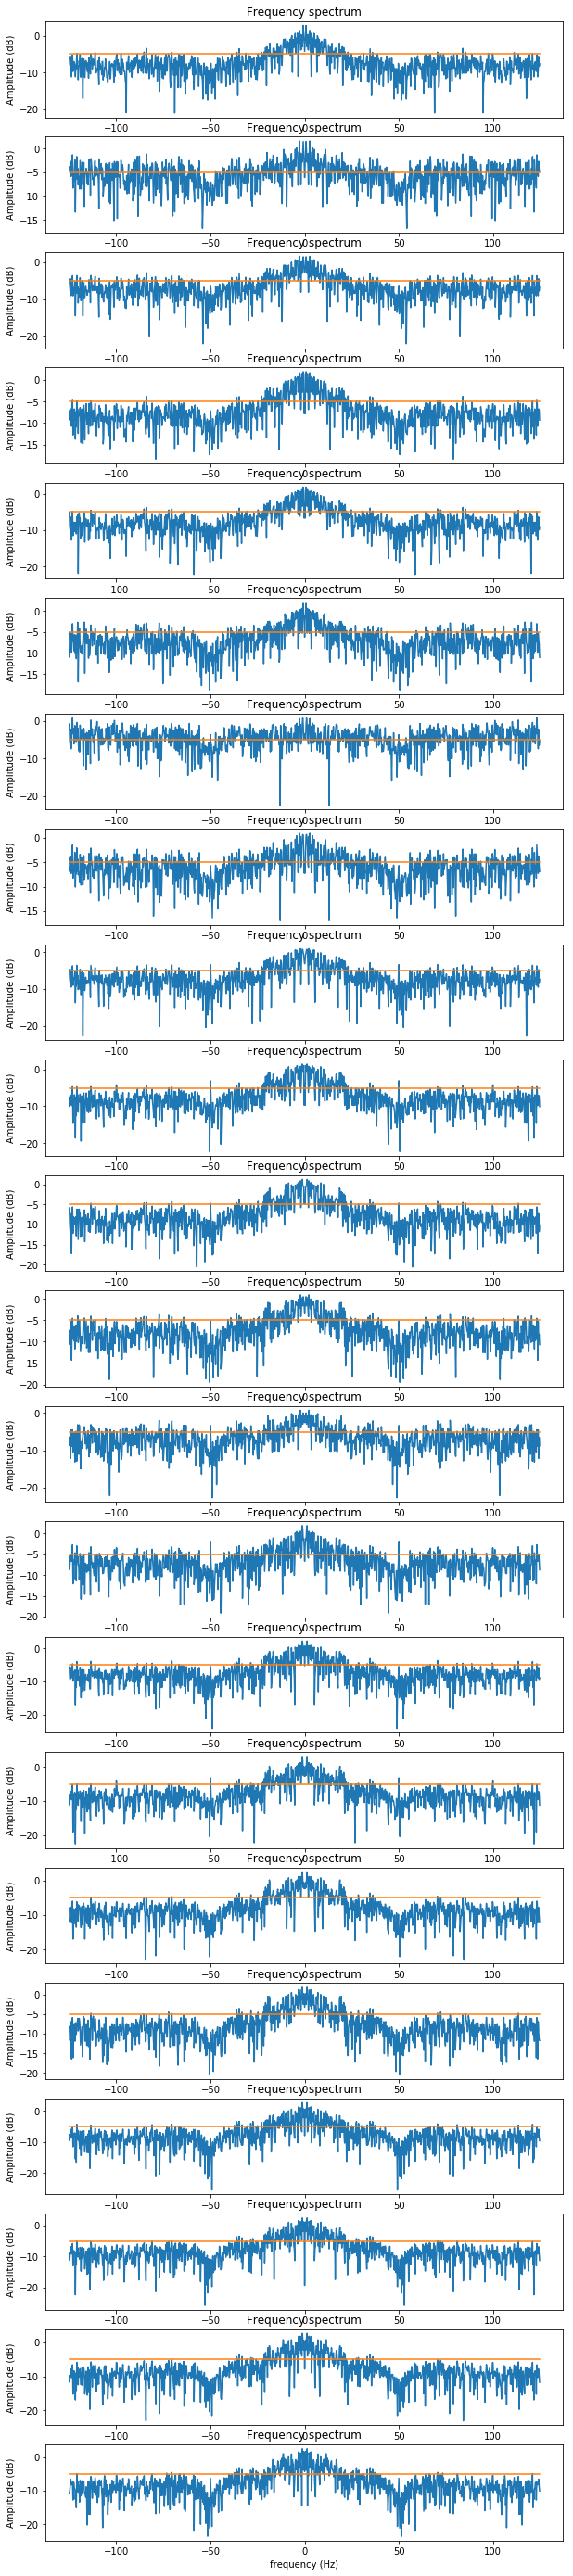

In [9]:
plot_spectrum_trail(250, X_train_valid[651, :22])

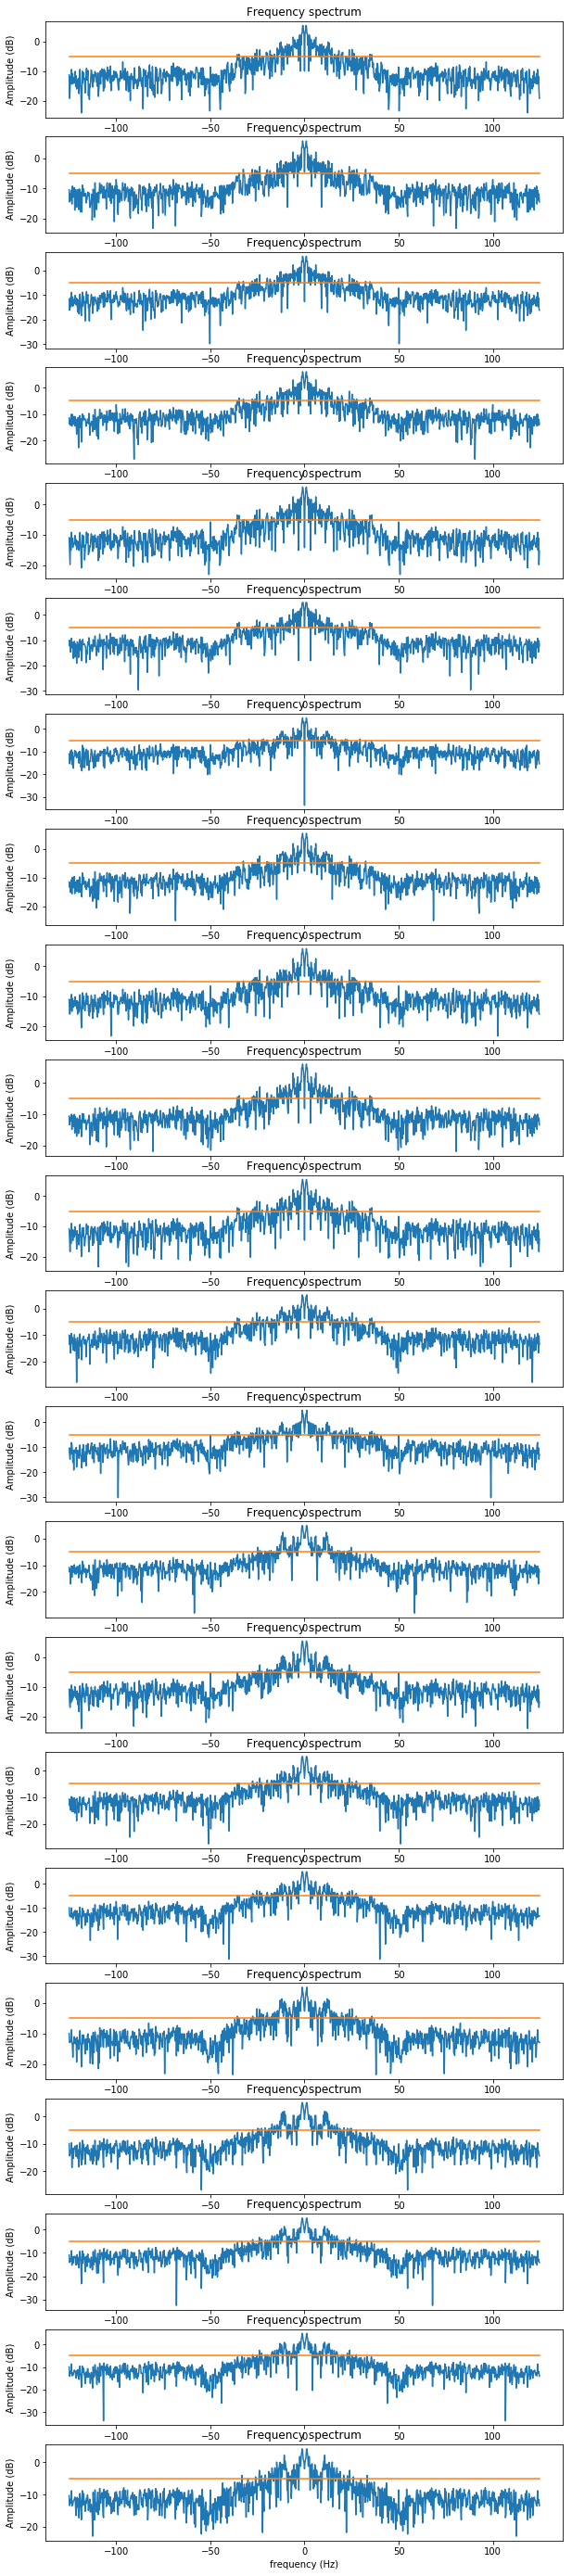

In [10]:
plot_spectrum_trail(250, X_train_valid[1, :22])

Noise intension varies in different trials. 

### Obtain the signal frequency band (max frequency with amplitude larger than -5dB)

In [11]:
def find_max_frequency_above_amplitude(X, f_s, threshold): 
    '''
    Parameters: 
    X: 3D ndarray (n1, n2, n_s), EEG dataset
    f_s: sampling frequency
    threshold: amplitude threshold in dB
    
    Return: 
    running_max_freq: max baseband frequency with amplitude larger than -5dB
    '''
    running_max_freq = 0
    eps = 1e-6
    
    for n1 in range(X.shape[0]):
        for n2 in range(X.shape[1]):
        
            n_s = len(X[n1, n2, :])  # number of sample points
        
            timestep = 1/f_s  
        
            spectrum = np.abs(np.fft.fft(X[n1, n2, :]))/n_s # Normalize by deviding n_s
            spectrum_dB = 10*np.log10(spectrum + eps)
        
            freq = np.fft.fftfreq(n_s, timestep)
        
            for i in range(len(spectrum_dB)):
                if spectrum_dB[i] > threshold: 
                    if abs(freq[i]) > running_max_freq:
                        running_max_freq = abs(freq[i])
                              
    return running_max_freq
    
    

### Find max frequency in: (1) various threshold, (2) various Filter set up

#### size=13, order=2

In [17]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 13, 2), f_s = 250, threshold = -5)
max_freq

29.75

In [28]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 13, 2), f_s = 250, threshold = -8)
max_freq_2

68.75

#### Size = 15, order = 2

In [19]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 15, 2), f_s = 250, threshold = -5)
max_freq

37.0

In [20]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 15, 2), f_s = 250, threshold = -8)
max_freq_2

50.0

#### size=13, order=3

In [29]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 13, 3), f_s = 250, threshold = -5)
max_freq

29.75

In [30]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 13, 3), f_s = 250, threshold = -8)
max_freq_2

68.75

#### Size = 13, Order = 4

In [21]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 13, 4), f_s = 250, threshold = -5)
max_freq

41.5

In [22]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 15, 4), f_s = 250, threshold = -8)
max_freq_2

109.25

#### Size = 9, Order = 2

In [24]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 9, 2), f_s = 250, threshold = -5)
max_freq

68.75

In [25]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 9, 2), f_s = 250, threshold = -8)
max_freq_2

125.0

#### Size = 9, Order = 4

In [26]:
max_freq = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 9, 4), f_s = 250, threshold = -5)
max_freq

94.25

In [27]:
max_freq_2 = find_max_frequency_above_amplitude(savgol_filter(X_train_valid[:, :22, :], 9, 4), f_s = 250, threshold = -8)
max_freq_2

125.0

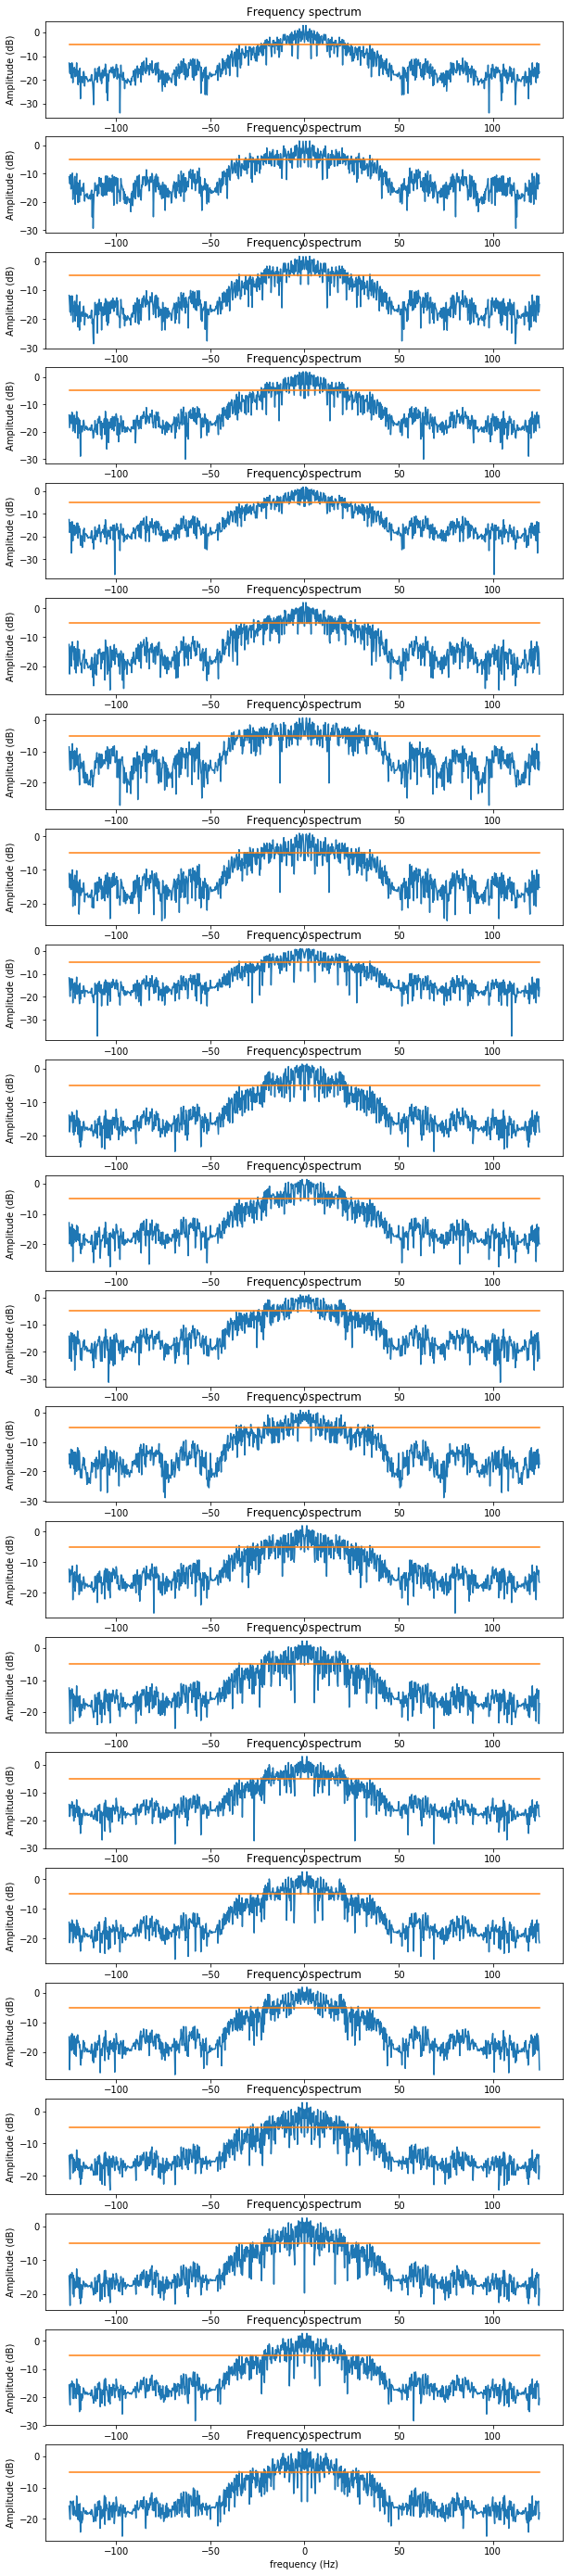

In [23]:
# plot_spectrum_trail(250, X_train_valid[651])

plot_spectrum_trail(250, savgol_filter(X_train_valid[651, :22], 13, 4))


In [44]:
from scipy.signal import savgol_filter

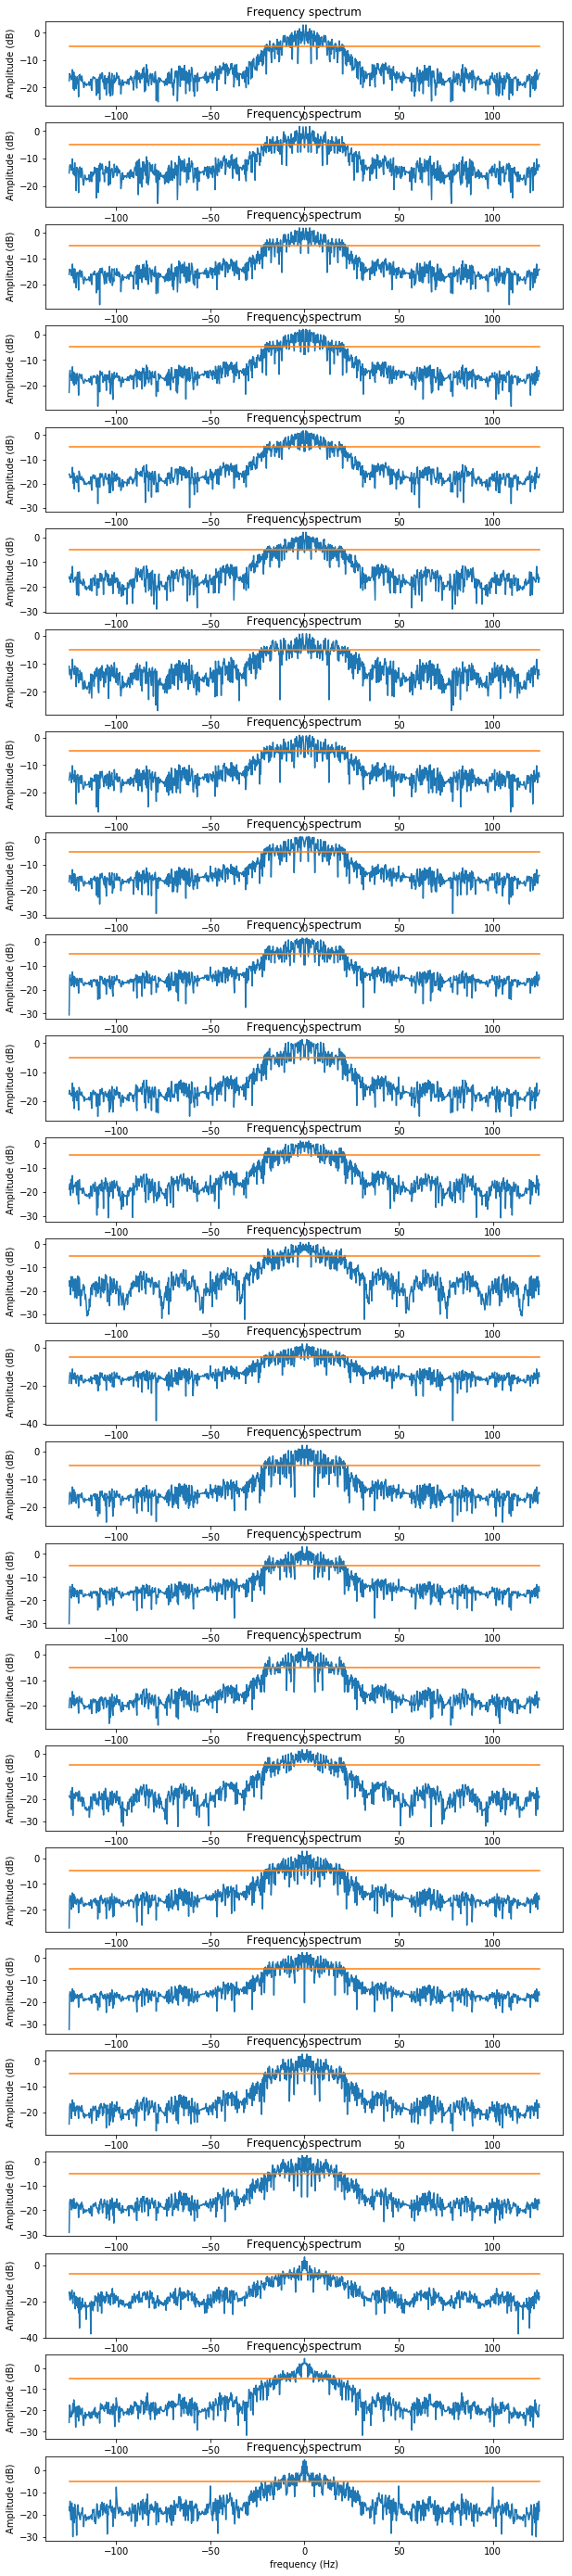

In [61]:
x_smooth = savgol_filter(X_train_valid[651, :, :], 13, 2)
plot_spectrum_trail(250,x_smooth)

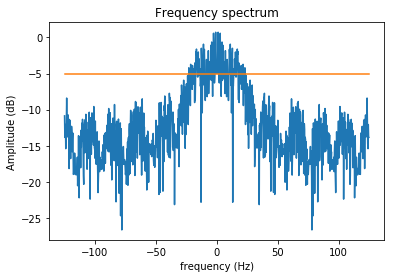

In [59]:
plot_spectrum(250, x_smooth)

In [89]:
'''
To do: 
- Apply Savitzky–Golay filter
- Subsample data with have of the sampling frequency
'''
from scipy.signal import savgol_filter

X_train_valid = savgol_filter(X_train_valid[:, :22, :], 13, 2)
X_test = savgol_filter(X_test[:, :22, :], 13, 2)
    
X_train_valid = np.vstack(( X_train_valid[:,:,[(2*i) for i in range(500)]] , X_train_valid[:,:,[(2*i+1) for i in range(500)]]))
    
X_test = np.vstack(( X_test[:,:,[(2*i) for i in range(500)]] , X_test[:,:,[(2*i+1) for i in range(500)]]))
    
y_train_valid = np.concatenate((y_train_valid, y_train_valid))
y_test = np.concatenate((y_test, y_test))

In [96]:
y_train_valid.shape

(8460,)

In [95]:
'''
To do: 
- Apply Savitzky–Golay filter
- Subsample data with one forth of the sampling frequency
'''
from scipy.signal import savgol_filter

X_train_valid = savgol_filter(X_train_valid[:, :22, :], 13, 2)
X_test = savgol_filter(X_test[:, :22, :], 13, 2)
    
X_train_valid = np.vstack(( X_train_valid[:,:,[(4*i) for i in range(250)]] , X_train_valid[:,:,[(4*i+1) for i in range(250)]], X_train_valid[:,:,[(4*i+2) for i in range(250)]], X_train_valid[:,:,[(4*i+3) for i in range(250)]]))


X_test = np.vstack(( X_test[:,:,[(4*i) for i in range(250)]] , X_test[:,:,[(4*i+1) for i in range(250)]], X_test[:,:,[(4*i+2) for i in range(250)]], X_test[:,:,[(4*i+3) for i in range(250)]]))
    
y_train_valid = np.concatenate((y_train_valid, y_train_valid, y_train_valid, y_train_valid))
y_test = np.concatenate((y_test, y_test, y_test, y_test))
